In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
plt.style.use('ggplot')

# Dataset

In [2]:
# Simulation results for the last 1000 steps
dfr=pd.read_csv('../results/stationary_state.csv')
dfr.shape[0]

1000000

In [3]:
# Average time series of the last ticks by experiment
dfr_sum=dfr.groupby('experiment').mean()
dfr_sum.shape[0]

1000

# Random Forest parameter importance analysis

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GroupKFold
from sklearn.multioutput import MultiOutputRegressor

In [47]:
for i in range(len(dfr_sum.columns)): print(i, dfr_sum.columns[i])

0 mu-logistic-whaling-success
1 whaling-harm-prob
2 theta
3 mutation-prob
4 n-people
5 [step]
6 (mean) average-whale-hunt
7 (std) average-whale-hunt
8 (mean) average-help-others
9 (std) average-help-others
10 (mean) average-fitness
11 (std) average-fitness
12 (mean) average-resources
13 (std) average-resources
14 (mean) average-social-capital
15 (std) average-social-capital
16 (mean) average-disabled
17 (std) average-disabled


In [14]:
model_parameters=dfr_sum.columns[:5].to_list()
model_parameters

['mu-logistic-whaling-success',
 'whaling-harm-prob',
 'theta',
 'mutation-prob',
 'n-people']

In [8]:
X = dfr_sum.iloc[:, :4].values  # Model paramter (excecpt n-people)
y = dfr_sum.iloc[:, [6,8]].values  # Output variables: '(mean) average-whale-hunt' and '(mean) average-help-others'

In [9]:
# Random Forest model
seed=1234
base_model = RandomForestRegressor(n_estimators=100, random_state=seed)
model = MultiOutputRegressor(base_model)

# 5-fold cross-validation
gkf = KFold(n_splits=5)
scores = cross_val_score(model, X, y, cv=gkf)
print('Cross-validation scores:', scores)
print('Average cross-validation score:', np.mean(scores))

Cross-validation scores: [0.95469315 0.97026059 0.901791   0.92087927 0.94298818]
Average cross-validation score: 0.93812243973316


In [10]:
# Parameter importance by 5-fold cross-validation
parameter_importances = []
for train_index, test_index in gkf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    base_model = RandomForestRegressor(n_estimators=100, random_state=seed)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)
    fold_importances = [est.feature_importances_ for est in model.estimators_]
    parameter_importances.append(fold_importances)


In [16]:
# Parameter importance for (mean) average-whale-hunt
df_whale_hunt=pd.DataFrame([x[0] for x in parameter_importances],columns=model_parameters[:-1])
df_whale_hunt.to_csv('../results/parameter_importance_whale_hunt.csv',index=False)
df_whale_hunt.mean().sort_values(ascending=False)

theta                          0.505350
whaling-harm-prob              0.397600
mu-logistic-whaling-success    0.069124
mutation-prob                  0.027926
dtype: float64

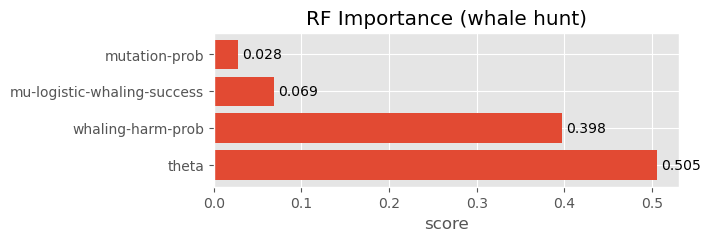

In [79]:
# Bar plot
dt=df_whale_hunt.mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(6, 2))
y_pos = np.arange(dt.shape[0])
ax.barh(y_pos, dt.values, align='center')
for i, v in enumerate(dt):
    ax.text(v + 0.05, i, '%0.3f'%v, va='center', ha='right')
ax.set_yticks(y_pos, labels=dt.index)
ax.set_title('RF Importance (whale hunt)')
ax.set_xlabel('score')
plt.savefig('../figures/rf_importance_whale_hunt.svg',format='svg',bbox_inches='tight')
plt.show()

In [17]:
# Parameter importance for (mean) average-help-others
df_help_others=pd.DataFrame([x[1] for x in parameter_importances],columns=model_parameters[:-1])
df_help_others.to_csv('../results/parameter_importance_help_others.csv',index=False)
df_help_others.mean().sort_values(ascending=False)

theta                          0.764472
whaling-harm-prob              0.195655
mu-logistic-whaling-success    0.021083
mutation-prob                  0.018790
dtype: float64

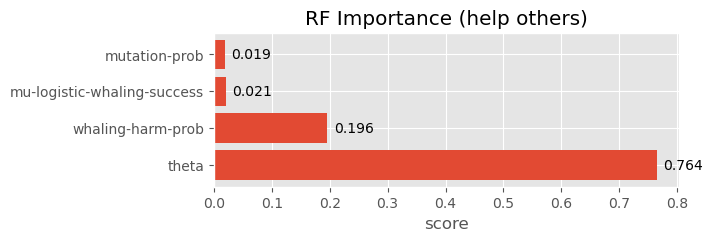

In [78]:
# Bar plot
dt=df_help_others.mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(6, 2))
y_pos = np.arange(dt.shape[0])
ax.barh(y_pos, dt.values, align='center')
for i, v in enumerate(dt):
    ax.text(v + 0.08, i, '%0.3f'%v, va='center', ha='right')
ax.set_yticks(y_pos, labels=dt.index)
ax.set_title('RF Importance (help others)')
ax.set_xlabel('score')
plt.savefig('../figures/rf_importance_help_others.svg',format='svg',bbox_inches='tight')
plt.show()

# Explainable Boosting Machine

In [4]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.metrics import mean_squared_error
import pickle

## (1) EBM for '(mean) average-whale-hunt'

In [5]:
for i in range(len(dfr_sum.columns)): print(i, dfr_sum.columns[i])

0 mu-logistic-whaling-success
1 whaling-harm-prob
2 theta
3 mutation-prob
4 n-people
5 [step]
6 (mean) average-whale-hunt
7 (std) average-whale-hunt
8 (mean) average-help-others
9 (std) average-help-others
10 (mean) average-fitness
11 (std) average-fitness
12 (mean) average-resources
13 (std) average-resources
14 (mean) average-social-capital
15 (std) average-social-capital
16 (mean) average-disabled
17 (std) average-disabled


In [51]:
seed=1234

# Simulation data (the last 1000 steps that passed the stationary test)
X = dfr_sum.iloc[:,:4].values  # Model paramter (excecpt n-people)
y = dfr_sum.iloc[:, 6].values  # Output variables: '(mean) average-whale-hunt' 

# EBM regression model
model=ExplainableBoostingRegressor(random_state=seed,smoothing_rounds=5000)

# Train the model
model.fit(X,y)
print('MSE: %0.4f' % mean_squared_error(y,model.predict(X)))

MSE: 0.0098


In [53]:
# Save model
pickle.dump(model, open('../results/ebm_average_whale_hunt.pkl', 'wb'))

In [27]:
# Load model
model=pickle.load(open('../results/ebm_average_whale_hunt.pkl', 'rb'))

In [ ]:
# 'interpret' package visualization 
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
show(model.explain_global())

In [6]:
feature_names={'feature_0000':'mu-logistic-whaling-success',
 'feature_0001':'whaling-harm-prob',
 'feature_0002':'theta',
 'feature_0003':'mutation-prob'}

In [7]:
# Change feature names
names=model.explain_global().feature_names
for fn in feature_names.keys():
    for i in range(len(names)):
        if fn in names[i]:
            names[i]=names[i].replace(fn,feature_names[fn])
names

['mu-logistic-whaling-success',
 'whaling-harm-prob',
 'theta',
 'mutation-prob',
 'mu-logistic-whaling-success & whaling-harm-prob',
 'mu-logistic-whaling-success & theta',
 'whaling-harm-prob & theta',
 'theta & mutation-prob']

In [28]:
# Global interpretation
ebm_global = model.explain_global()

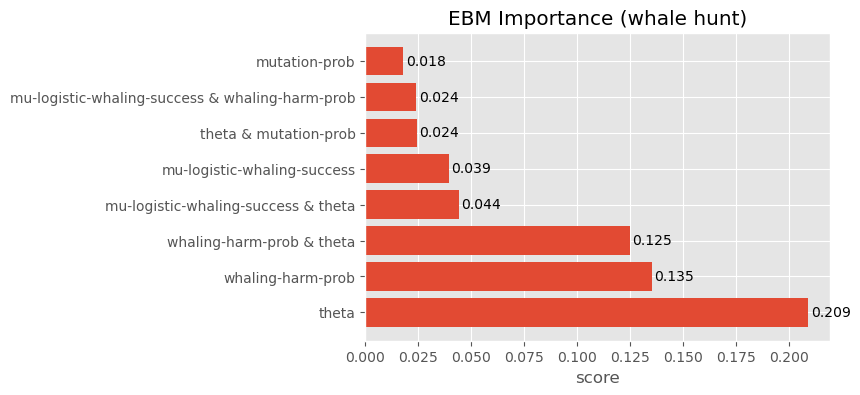

In [27]:
# Global Parameter importance
df=pd.DataFrame(ebm_global.data()) 
df['names']=names
df.sort_values(by='scores',ascending=False,inplace=True) # sorted by scores
fig, ax = plt.subplots(figsize=(6, 4))
y_pos = np.arange(df.shape[0])
ax.barh(y_pos, df['scores'], align='center')
for i, v in enumerate(df['scores']):
    ax.text(v + 0.02, i, '%0.3f'%v, va='center', ha='right')
ax.set_yticks(y_pos, labels=df['names'])
#ax.invert_yaxis()  
ax.set_xlabel('score')
ax.set_title('EBM Importance (whale hunt)')
plt.savefig('../figures/ebm_importance_whale_hunt.svg',format='svg',bbox_inches='tight')
plt.show()

In [11]:
# Plot function of the contribution of each predictor
def plot_individual_variable(var,name,dt,export=False,ylim=None):
    # Score-variable plot
    x_vals = dt.get('names')[1:]
    y_vals = dt.get('scores')
    y_hi = dt.get('upper_bounds')
    y_lo = dt.get('lower_bounds')

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x_vals, y_vals)
    ax.fill_between(x_vals, y_lo, y_hi, color='gray', alpha=0.5, label='upper-lower bounds')
    ax.set_ylabel('score')
    ax.set_xlabel(name)
    ax.set_title(var.replace('_', ' '),fontsize=12)
    ax.set(xlim=(0,0.1) if name=='mutation-prob' else (0,1))
    if ylim: ax.set(ylim=(ylim[0],ylim[1]))
    if export:
        plt.savefig('../figures/ebm_' + var + '_'+ name + '.svg',format='svg',bbox_inches='tight')
    fig.show()

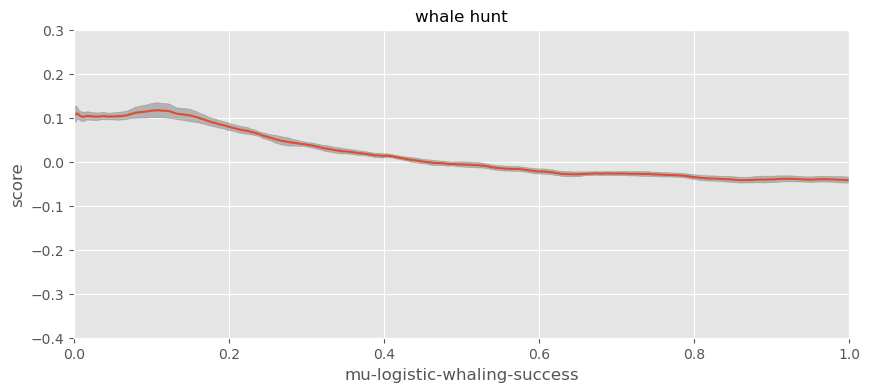

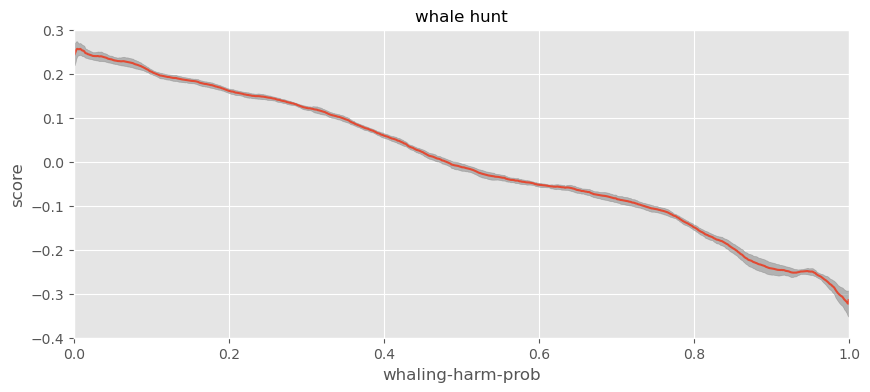

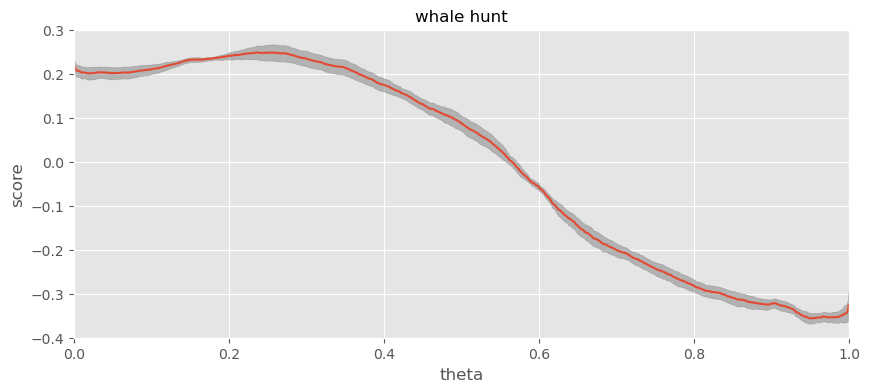

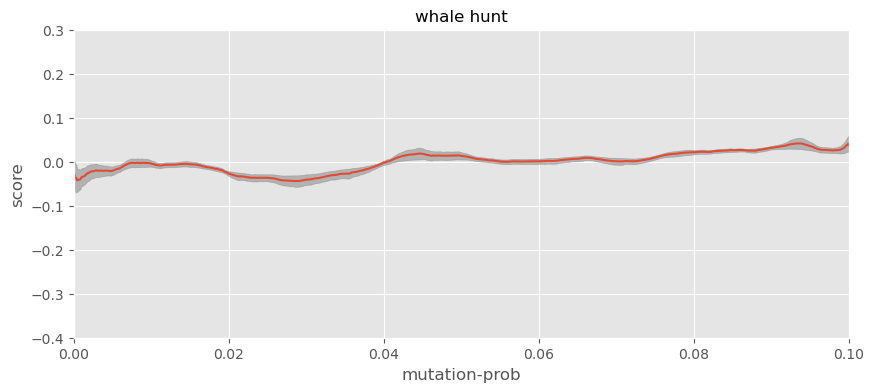

In [12]:
with warnings.catch_warnings(record=True) as w:
    for i,v in enumerate(names[:4]):
        plot_individual_variable('whale_hunt',names[i],ebm_global.data(i),True,(-0.4,0.3))

In [13]:
def plot_interaction(var,name1,name2,dt,export=False):
    plt.imshow(dt.get('scores'), cmap='viridis',origin='lower',extent=[0,1,0,1])
    plt.colorbar(label='Interaction score')
    plt.xlabel(name2)
    plt.ylabel(name1)
    plt.title(var.replace('_', ' '),fontsize=12)
    if export:
        plt.savefig('../figures/ebm_' + var + '_' + name1 + '_' + name2 + '.svg',format='svg',bbox_inches='tight')
    fig.show()

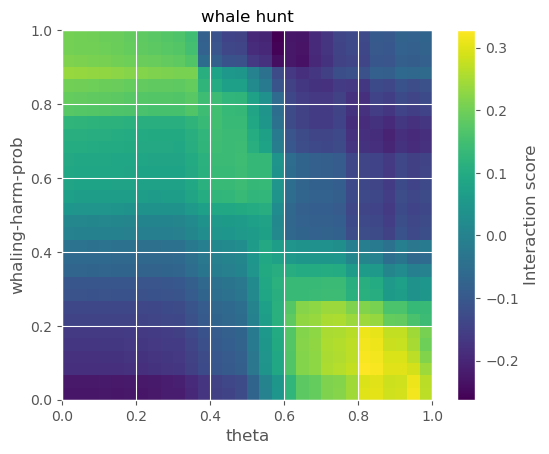

In [14]:
with warnings.catch_warnings(record=True) as w:
    plot_interaction('whale_hunt',names[6].split(' & ')[0],names[6].split(' & ')[1],ebm_global.data(6),True)

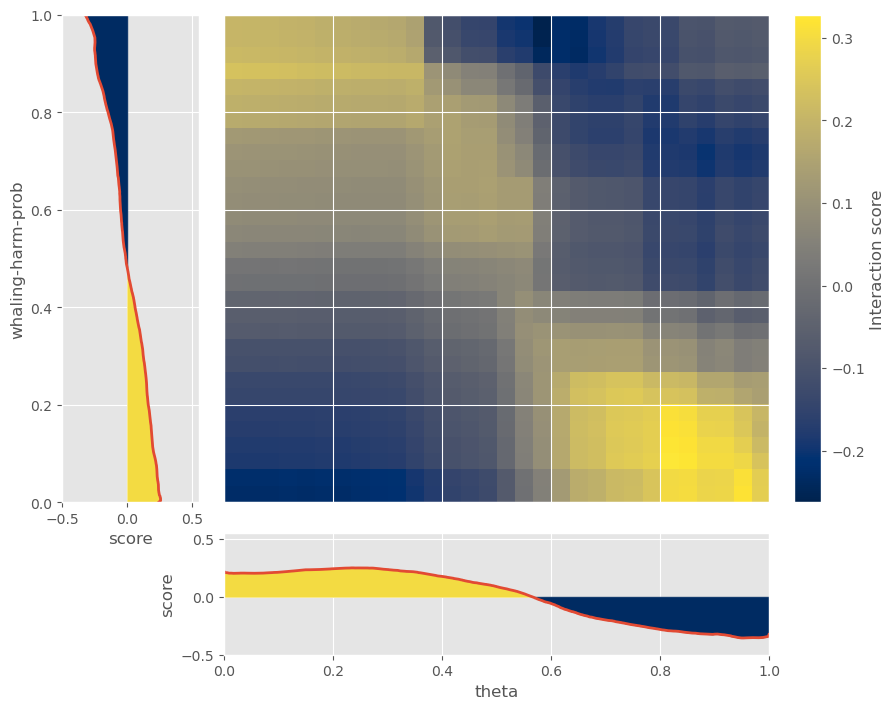

In [56]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Data
dt_interaction=ebm_global.data(6) # Interaction score
dt_parameter_x=ebm_global.data(2) # theta
dt_parameter_y=ebm_global.data(1) # whaling-harm-prob

# Figure layout
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 3,  width_ratios=(1, 4,0.5), height_ratios=(4, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.1, hspace=0.1)

ax_heatmap = fig.add_subplot(gs[0, 1])
ax_ploty = fig.add_subplot(gs[0, 0],sharey=ax_heatmap)
ax_plotx = fig.add_subplot(gs[1, 1],sharex=ax_heatmap)
ax_colorbar = fig.add_subplot(gs[0, 2])
ax_colorbar.axis('off')

# Create a hetamap plot in the middle
hmp = ax_heatmap.imshow(dt_interaction.get('scores'), cmap='cividis',origin='lower',extent=[0,1,0,1],aspect='auto')
divider = make_axes_locatable(ax_colorbar)
cax = divider.append_axes("left", size="75%", pad=0.05)
fig.colorbar(hmp, ax=ax_colorbar, cax=cax, label='Interaction score')
ax_heatmap.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
ax_heatmap.tick_params(axis='both',labelcolor='white')
box = ax_heatmap.get_position()

# For filling the area above and below the line
cmap = plt.get_cmap('cividis')
color_positive = cmap(0.95)  # color at the high end of the colormap
color_negative = cmap(0.05)  # color at the low end of the colormap

# Create line plot above the contour plot: theta
x_vals = dt_parameter_x.get('names')[1:]
y_vals = dt_parameter_x.get('scores')
ax_plotx.plot(x_vals, y_vals,linewidth=2)
# Fill the area above and below the line
ax_plotx.fill_between(x_vals, y_vals, where=y_vals>=0, color=color_positive)
ax_plotx.fill_between(x_vals, y_vals, where=y_vals<0, color=color_negative)
ax_plotx.set(xlim=(0,1))
ax_plotx.set(ylim=(-0.5,0.55))
ax_plotx.set_xlabel('theta')
ax_plotx.set_ylabel('score')
#ax_plotx.axhline(0, color='black',linewidth=0.5, linestyle='--')

# Create line plot to the left of the contour plot: whaling-harm-prob
x_vals = dt_parameter_y.get('names')[1:]
y_vals = dt_parameter_y.get('scores')
ax_ploty.plot(y_vals,x_vals,linewidth=2)
# Fill the area above and below the line
ax_ploty.fill_betweenx(x_vals, y_vals, where=y_vals>=0, color=color_positive)
ax_ploty.fill_betweenx(x_vals, y_vals, where=y_vals<0, color=color_negative)
ax_ploty.set(ylim=(0,1))
ax_ploty.set(xlim=(-0.5,0.55))
ax_ploty.set_ylabel('whaling-harm-prob')
ax_ploty.set_xlabel('score')
#ax_ploty.axvline(0, color='black',linewidth=0.5, linestyle='--')

plt.savefig('../figures/ebm_interaction_whale_hunt_theta_whaling_harm_prob_2.svg',format='svg',bbox_inches='tight')
plt.show()

## (2) EBM for '(mean) average-help-others'

In [15]:
for i in range(len(dfr_sum.columns)): print(i, dfr_sum.columns[i])
seed=1234

0 mu-logistic-whaling-success
1 whaling-harm-prob
2 theta
3 mutation-prob
4 n-people
5 [step]
6 (mean) average-whale-hunt
7 (std) average-whale-hunt
8 (mean) average-help-others
9 (std) average-help-others
10 (mean) average-fitness
11 (std) average-fitness
12 (mean) average-resources
13 (std) average-resources
14 (mean) average-social-capital
15 (std) average-social-capital
16 (mean) average-disabled
17 (std) average-disabled


In [118]:
# Simulation data (the last 1000 steps that passed the stationary test)
X = dfr_sum.iloc[:,:4].values  # Model paramter (excecpt n-people)
y = dfr_sum.iloc[:, 8].values  # Output variables: '(mean) average-help-others' 

# EBM regression model
model=ExplainableBoostingRegressor(random_state=seed,smoothing_rounds=5000)

# Train the model
model.fit(X,y)
print('MSE: %0.4f' % mean_squared_error(y,model.predict(X)))

MSE: 0.0065


In [120]:
# Save model
pickle.dump(model, open('../results/ebm_average_help_others.pkl', 'wb'))

In [57]:
# Load model
model=pickle.load(open('../results/ebm_average_help_others.pkl', 'rb'))

In [ ]:
# 'interpret' package visualization 
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
show(model.explain_global())

In [6]:
feature_names={'feature_0000':'mu-logistic-whaling-success',
 'feature_0001':'whaling-harm-prob',
 'feature_0002':'theta',
 'feature_0003':'mutation-prob'}

In [7]:
# Change feature names
names=model.explain_global().feature_names
for fn in feature_names.keys():
    for i in range(len(names)):
        if fn in names[i]:
            names[i]=names[i].replace(fn,feature_names[fn])
names

['mu-logistic-whaling-success',
 'whaling-harm-prob',
 'theta',
 'mutation-prob',
 'mu-logistic-whaling-success & whaling-harm-prob',
 'mu-logistic-whaling-success & theta',
 'whaling-harm-prob & theta',
 'theta & mutation-prob']

In [58]:
# Global interpretation
ebm_global = model.explain_global()

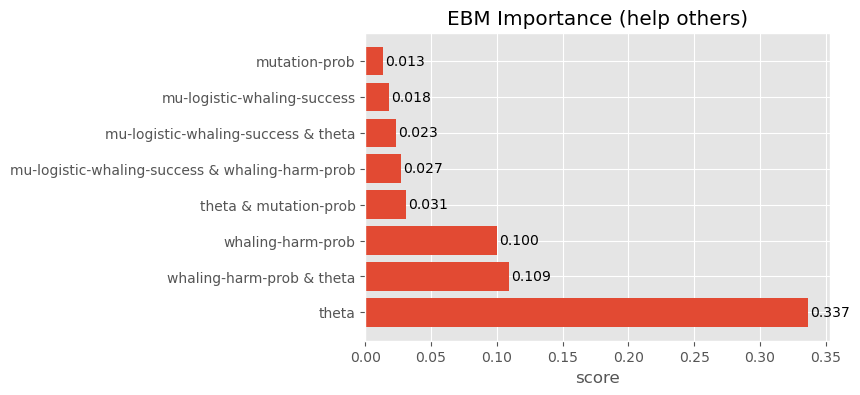

In [20]:
# Global Parameter importance
df=pd.DataFrame(ebm_global.data()) 
df['names']=names
df.sort_values(by='scores',ascending=False,inplace=True) # sorted by scores
fig, ax = plt.subplots(figsize=(6, 4))
y_pos = np.arange(df.shape[0])
ax.barh(y_pos, df['scores'], align='center')
for i, v in enumerate(df['scores']):
    ax.text(v + 0.032, i, '%0.3f'%v, va='center', ha='right')
ax.set_yticks(y_pos, labels=df['names'])
#ax.invert_yaxis()  
ax.set_xlabel('score')
ax.set_title('EBM Importance (help others)')
plt.savefig('../figures/ebm_importance_help_others.svg',format='svg',bbox_inches='tight')
plt.show()

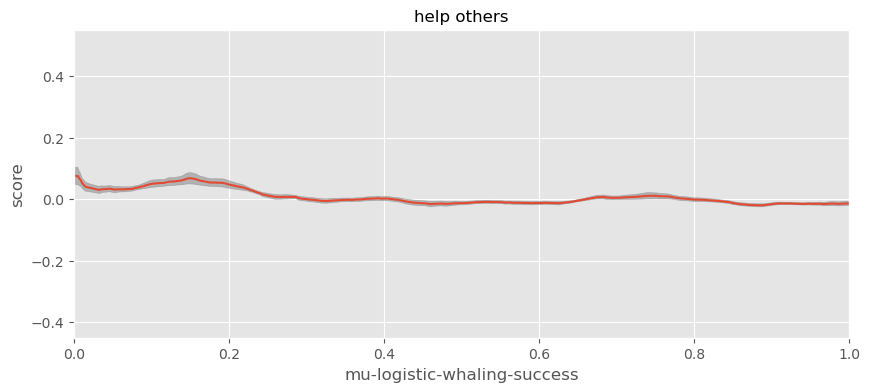

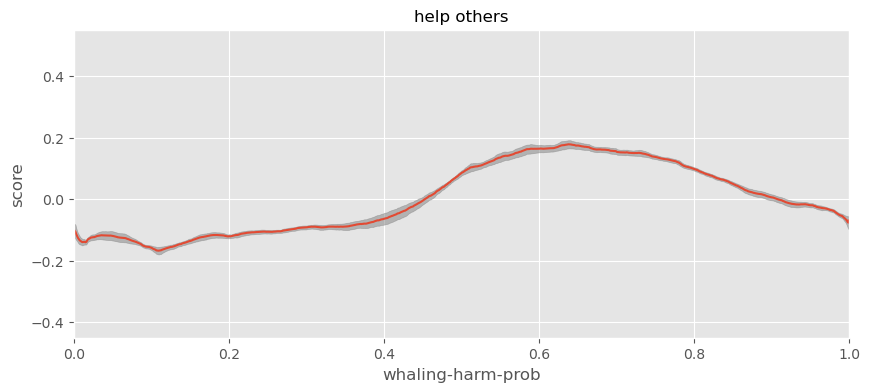

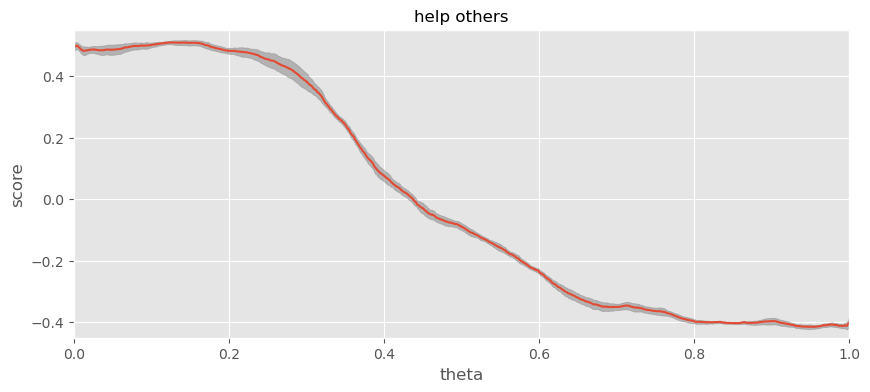

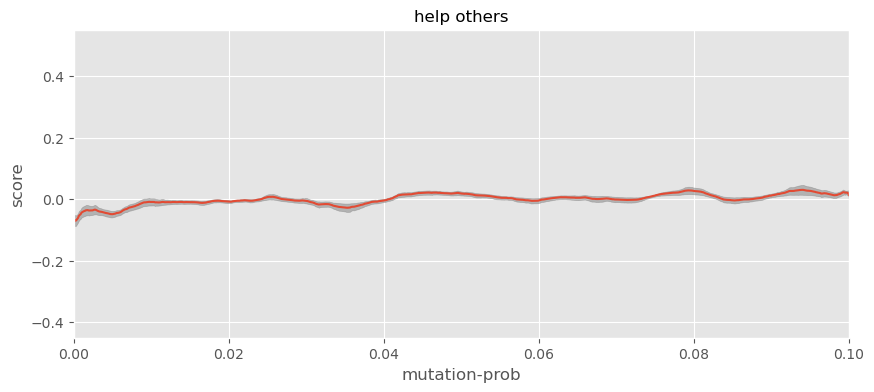

In [21]:
with warnings.catch_warnings(record=True) as w:
    for i,v in enumerate(names[:4]):
        plot_individual_variable('help_others',names[i],ebm_global.data(i),True,(-0.45,0.55))

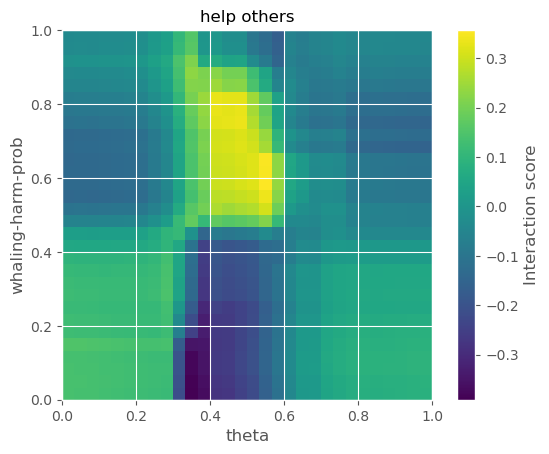

In [22]:
with warnings.catch_warnings(record=True) as w:
    plot_interaction('help_others',names[6].split(' & ')[0],names[6].split(' & ')[1],ebm_global.data(6),True)

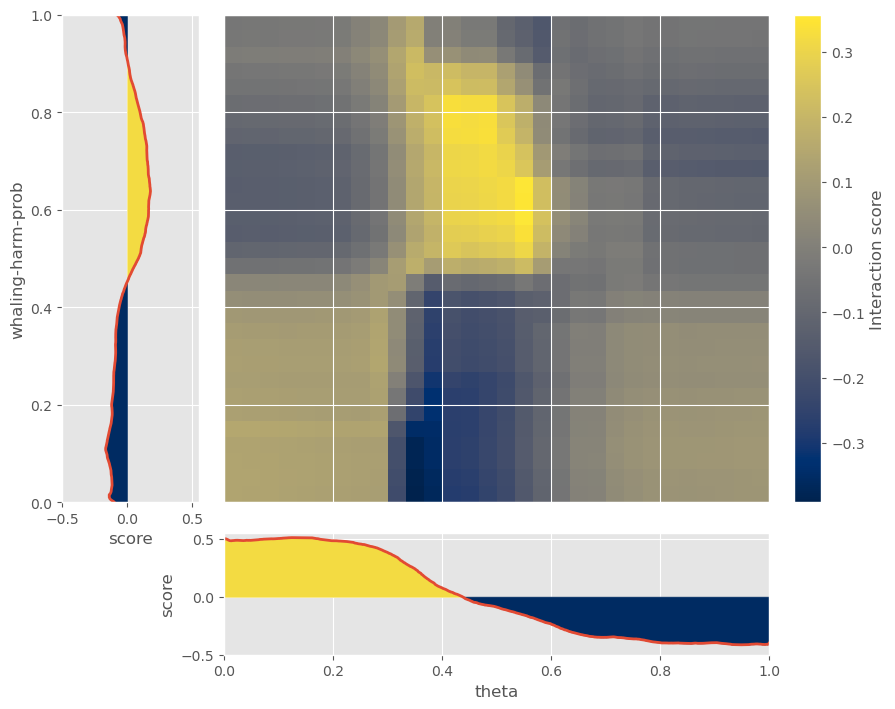

In [59]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Data
dt_interaction=ebm_global.data(6) # Interaction score
dt_parameter_x=ebm_global.data(2) # theta
dt_parameter_y=ebm_global.data(1) # whaling-harm-prob

# Figure layout
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 3,  width_ratios=(1, 4,0.5), height_ratios=(4, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.1, hspace=0.1)

ax_heatmap = fig.add_subplot(gs[0, 1])
ax_ploty = fig.add_subplot(gs[0, 0],sharey=ax_heatmap)
ax_plotx = fig.add_subplot(gs[1, 1],sharex=ax_heatmap)
ax_colorbar = fig.add_subplot(gs[0, 2])
ax_colorbar.axis('off')

# Create a hetamap plot in the middle
hmp = ax_heatmap.imshow(dt_interaction.get('scores'), cmap='cividis',origin='lower',extent=[0,1,0,1],aspect='auto')
divider = make_axes_locatable(ax_colorbar)
cax = divider.append_axes("left", size="75%", pad=0.05)
fig.colorbar(hmp, ax=ax_colorbar, cax=cax, label='Interaction score')
ax_heatmap.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
ax_heatmap.tick_params(axis='both',labelcolor='white')
box = ax_heatmap.get_position()

# For filling the area above and below the line
cmap = plt.get_cmap('cividis')
color_positive = cmap(0.95)  # color at the high end of the colormap
color_negative = cmap(0.05)  # color at the low end of the colormap

# Create line plot above the contour plot: theta
x_vals = dt_parameter_x.get('names')[1:]
y_vals = dt_parameter_x.get('scores')
ax_plotx.plot(x_vals, y_vals,linewidth=2)
# Fill the area above and below the line
ax_plotx.fill_between(x_vals, y_vals, where=y_vals>=0, color=color_positive)
ax_plotx.fill_between(x_vals, y_vals, where=y_vals<0, color=color_negative)
ax_plotx.set(xlim=(0,1))
ax_plotx.set(ylim=(-0.5,0.55))
ax_plotx.set_xlabel('theta')
ax_plotx.set_ylabel('score')
#ax_plotx.axhline(0, color='black',linewidth=0.5, linestyle='--')

# Create line plot to the left of the contour plot: whaling-harm-prob
x_vals = dt_parameter_y.get('names')[1:]
y_vals = dt_parameter_y.get('scores')
ax_ploty.plot(y_vals,x_vals,linewidth=2)
# Fill the area above and below the line
ax_ploty.fill_betweenx(x_vals, y_vals, where=y_vals>=0, color=color_positive)
ax_ploty.fill_betweenx(x_vals, y_vals, where=y_vals<0, color=color_negative)
ax_ploty.set(ylim=(0,1))
ax_ploty.set(xlim=(-0.5,0.55))
ax_ploty.set_ylabel('whaling-harm-prob')
ax_ploty.set_xlabel('score')
#ax_ploty.axvline(0, color='black',linewidth=0.5, linestyle='--')

plt.savefig('../figures/ebm_interaction_help_others_theta_whaling_harm_prob_2.svg',format='svg',bbox_inches='tight')
plt.show()

# Deprecated

In [ ]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Data
dt_interaction=ebm_global.data(6) # Interaction score
dt_parameter_x=ebm_global.data(2) # theta
dt_parameter_y=ebm_global.data(1) # whaling-harm-prob

# Figure layout
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 3,  width_ratios=(1, 4,0.5), height_ratios=(4, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.1, hspace=0.1)
ax_ploty = fig.add_subplot(gs[0, 0])
ax_plotx = fig.add_subplot(gs[1, 1])
ax_heatmap = fig.add_subplot(gs[0, 1], sharex=ax_plotx, sharey=ax_ploty)
ax_colorbar = fig.add_subplot(gs[0, 2])
ax_colorbar.axis('off')

# Create a hetamap plot in the middle
hmp = ax_heatmap.imshow(dt_interaction.get('scores'), cmap='viridis',origin='lower',extent=[0,1,0,1],aspect='auto')
divider = make_axes_locatable(ax_colorbar)
cax = divider.append_axes("left", size="75%", pad=0.05)
fig.colorbar(hmp, ax=ax_colorbar, cax=cax, label='Interaction score')
ax_heatmap.set_xticklabels([])
ax_heatmap.set_yticklabels([])
box = ax_heatmap.get_position()

# Create line plot above the contour plot: theta
x_vals = dt_parameter_x.get('names')[1:]
y_vals = dt_parameter_x.get('scores')
ax_plotx.plot(x_vals, y_vals)
ax_plotx.set(xlim=(0,1))
ax_plotx.set(ylim=(-0.5,0.55))
ax_plotx.set_xlabel('theta')
ax_plotx.set_ylabel('score')
ax_plotx.axhline(0, color='black',linewidth=0.5, linestyle='--')

# Create line plot to the left of the contour plot: whaling-harm-prob
x_vals = dt_parameter_y.get('names')[1:]
y_vals = dt_parameter_y.get('scores')
ax_ploty.plot(y_vals,x_vals)
ax_ploty.set(ylim=(0,1))
ax_ploty.set(xlim=(-0.5,0.55))
ax_ploty.set_ylabel('whaling-harm-prob')
ax_ploty.set_xlabel('score')
ax_ploty.axvline(0, color='black',linewidth=0.5, linestyle='--')

plt.savefig('../figures/ebm_interaction_help_others_theta_whaling_harm_prob_2.svg',format='svg',bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

dt_interaction=ebm_global.data(6) # Interaction score
dt_parameter_x=ebm_global.data(2) # theta
dt_parameter_y=ebm_global.data(1) # whaling-harm-prob

fig = plt.figure(figsize=(8, 8))
gs0 = gridspec.GridSpec(4, 4, figure=fig)

# Create a hetamap plot in the middle
ax2 = fig.add_subplot(gs0[:-1, 1:])
hmp = ax2.imshow(dt_interaction.get('scores'), cmap='viridis',origin='lower',extent=[0,1,0,1])
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(hmp, ax=ax2,cax=cax,label='Interaction score')
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Create line plot above the contour plot: theta
ax3 = fig.add_subplot(gs0[-1, 1:])
x_vals = dt_parameter_x.get('names')[1:]
y_vals = dt_parameter_x.get('scores')
y_hi = dt_parameter_x.get('upper_bounds')
y_lo = dt_parameter_x.get('lower_bounds')
ax3.plot(x_vals, y_vals)
#ax3.fill_between(x_vals, y_lo, y_hi, color='gray', alpha=0.5, label='upper-lower bounds')
ax3.set(xlim=(0,1))
ax3.set(ylim=(-0.5,0.55))
#ax3.set_xticklabels([])
#ax3.set_yticklabels([])
ax3.set_xlabel('theta')
ax3.set_ylabel('score')
box = ax3.get_position()
ax3.set_position([box.x0, box.y0+0.05, box.width*0.95, box.height*0.8])

# Create line plot to the left of the contour plot: whaling-harm-prob
ax1 = fig.add_subplot(gs0[:-1, 0])
x_vals = dt_parameter_y.get('names')[1:]
y_vals = dt_parameter_y.get('scores')
y_hi = dt_parameter_y.get('upper_bounds')
y_lo = dt_parameter_y.get('lower_bounds')

ax1.plot(y_vals,x_vals)
#ax1.fill_between(x_vals, y_lo, y_hi, color='gray', alpha=0.5, label='upper-lower bounds')
ax1.set(ylim=(0,1))
ax1.set(xlim=(-0.5,0.55))
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_ylabel('whaling-harm-prob')
ax1.set_xlabel('score')
box = ax1.get_position()
ax1.set_position([box.x0*1.1, box.y0*1.05, box.width*0.95, box.height*0.95])

#fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig('../figures/ebm_interaction_help_others_theta_whaling_harm_prob_2.svg',format='svg',bbox_inches='tight')
plt.show()
